## Decision Tree and Random Forest Scoring for Diabetes Dataset - PostClass

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


plt.rcParams["figure.figsize"] = (10,6)
import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")
#pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
df = pd.read_csv("diabetes.csv")

In [3]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## Cleaning Outliers

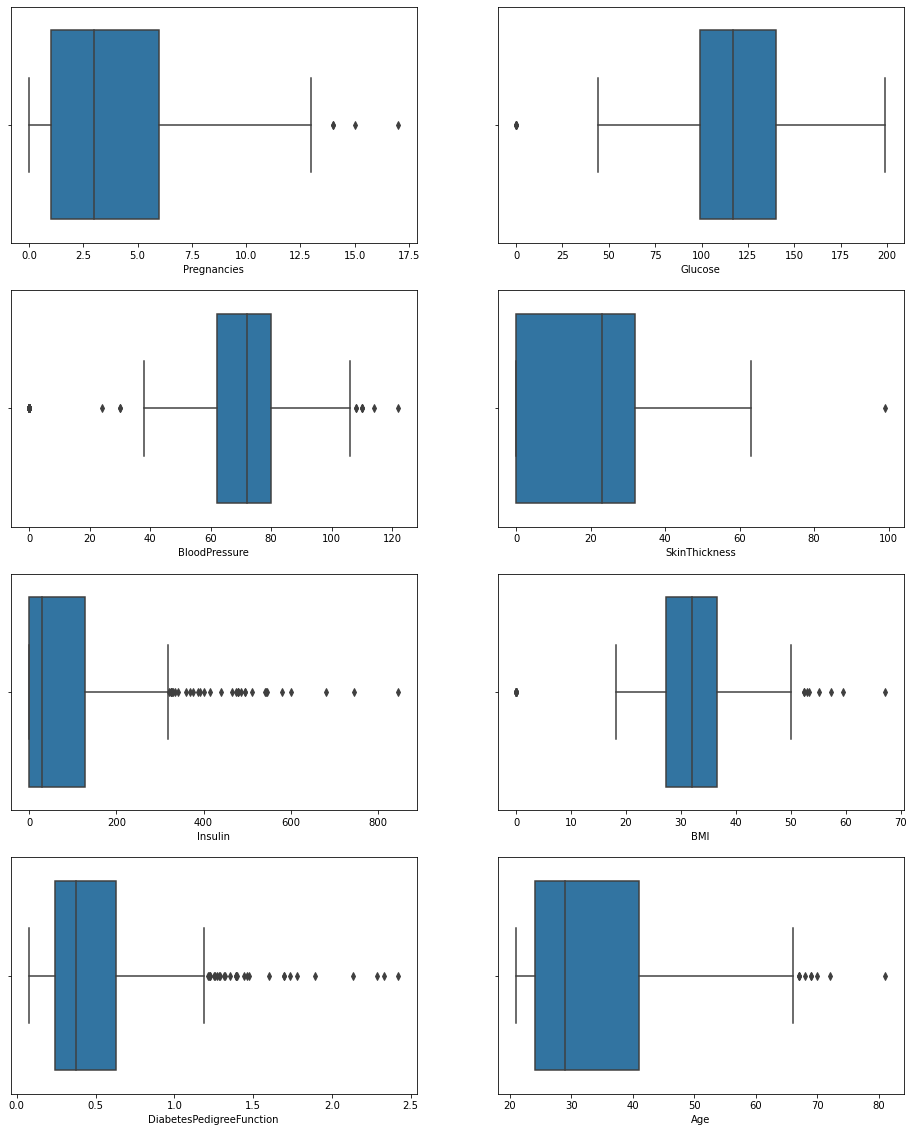

In [12]:
plt.figure(figsize=(16, 20))
i = 1
for column in df.drop(columns="Outcome").columns:
    plt.subplot(4,2,i)
    sns.boxplot(df[column])
    i += 1

In [13]:
df=df[df.SkinThickness<70]
df=df[df.Glucose>0]
df=df[df.BloodPressure>35]
df=df[df.BMI>0]

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 720 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               720 non-null    int64  
 1   Glucose                   720 non-null    int64  
 2   BloodPressure             720 non-null    int64  
 3   SkinThickness             720 non-null    int64  
 4   Insulin                   720 non-null    int64  
 5   BMI                       720 non-null    float64
 6   DiabetesPedigreeFunction  720 non-null    float64
 7   Age                       720 non-null    int64  
 8   Outcome                   720 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 56.2 KB


In [18]:
df.shape

(720, 9)

In [17]:
df.Outcome.value_counts(normalize=True) * 100
# Data çok dengeli dağılmamış ancak imbalance durum var diyemeyiz.

0    65.694444
1    34.305556
Name: Outcome, dtype: float64

## Train | Test Split and Scaling 

In [19]:
X = df.drop("Outcome",axis=1)
y = df["Outcome"]

In [20]:
from sklearn.model_selection import train_test_split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101, stratify=y)

## Modelling and Model Performance

In [27]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.model_selection import GridSearchCV

In [24]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score,f1_score

def eval_metric(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_pred = model.predict(X_test)
    
    print("Test_Set")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print()
    print("Train_Set")
    print(confusion_matrix(y_train, y_train_pred))
    print(classification_report(y_train, y_train_pred))

### Decision Tree

In [25]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(class_weight = "balanced", random_state=101)
dt_model.fit(X_train, y_train)
eval_metric(dt_model, X_train, y_train, X_test, y_test)

Test_Set
[[75 20]
 [23 26]]
              precision    recall  f1-score   support

           0       0.77      0.79      0.78        95
           1       0.57      0.53      0.55        49

    accuracy                           0.70       144
   macro avg       0.67      0.66      0.66       144
weighted avg       0.70      0.70      0.70       144


Train_Set
[[378   0]
 [  0 198]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       378
           1       1.00      1.00      1.00       198

    accuracy                           1.00       576
   macro avg       1.00      1.00      1.00       576
weighted avg       1.00      1.00      1.00       576



In [28]:
model = DecisionTreeClassifier(class_weight = "balanced", random_state=101)

scores = cross_validate(model, X_train, y_train, scoring = ['accuracy', 'precision', 'recall', 'f1'],
                        cv = 10)
df_scores = pd.DataFrame(scores, index = range(1, 11))

df_scores.mean()[2:]

test_accuracy     0.711766
test_precision    0.589251
test_recall       0.551316
test_f1           0.565202
dtype: float64

In [29]:
param_grid = {"splitter":["best", "random"],
              "max_features":[None, 3, 5, 7],
              "max_depth": [None, 4, 5, 6, 7, 8, 9, 10],
              "min_samples_leaf": [3, 5, 6,7],
              "min_samples_split": [11, 12, 14,15,16,17]}

In [30]:
model = DecisionTreeClassifier(class_weight = "balanced", random_state=101)

dt_grid_model = GridSearchCV(estimator=model,
                            param_grid=param_grid,
                            scoring='recall',
                            n_jobs = -1, verbose = 2, cv = 10).fit(X_train, y_train)

Fitting 10 folds for each of 1536 candidates, totalling 15360 fits


In [31]:
dt_grid_model.best_params_

{'max_depth': 4,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 11,
 'splitter': 'random'}

In [32]:
dt_grid_model.best_estimator_

DecisionTreeClassifier(class_weight='balanced', max_depth=4, max_features=3,
                       min_samples_leaf=3, min_samples_split=11,
                       random_state=101, splitter='random')

In [33]:
eval_metric(dt_grid_model, X_train, y_train, X_test, y_test)

Test_Set
[[44 51]
 [ 7 42]]
              precision    recall  f1-score   support

           0       0.86      0.46      0.60        95
           1       0.45      0.86      0.59        49

    accuracy                           0.60       144
   macro avg       0.66      0.66      0.60       144
weighted avg       0.72      0.60      0.60       144


Train_Set
[[179 199]
 [ 22 176]]
              precision    recall  f1-score   support

           0       0.89      0.47      0.62       378
           1       0.47      0.89      0.61       198

    accuracy                           0.62       576
   macro avg       0.68      0.68      0.62       576
weighted avg       0.75      0.62      0.62       576



In [34]:
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve, plot_roc_curve, roc_auc_score, roc_curve,\
                            average_precision_score

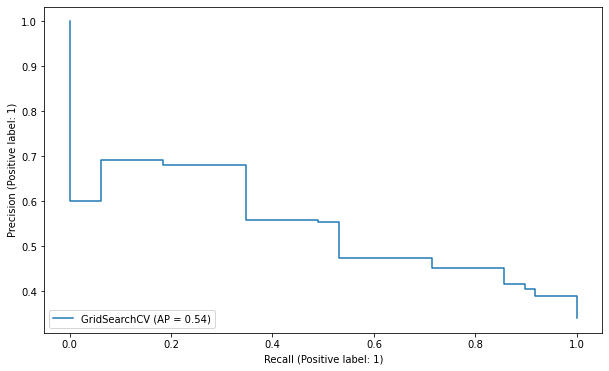

In [35]:
plot_precision_recall_curve(dt_grid_model, X_test, y_test);

### Random Forest

In [37]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

In [38]:
rf_model = RandomForestClassifier(class_weight = "balanced", random_state=101)
rf_model.fit(X_train, y_train)
eval_metric(rf_model, X_train, y_train, X_test, y_test)

Test_Set
[[83 12]
 [24 25]]
              precision    recall  f1-score   support

           0       0.78      0.87      0.82        95
           1       0.68      0.51      0.58        49

    accuracy                           0.75       144
   macro avg       0.73      0.69      0.70       144
weighted avg       0.74      0.75      0.74       144


Train_Set
[[378   0]
 [  0 198]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       378
           1       1.00      1.00      1.00       198

    accuracy                           1.00       576
   macro avg       1.00      1.00      1.00       576
weighted avg       1.00      1.00      1.00       576



In [39]:
model = RandomForestClassifier(class_weight = "balanced", random_state=101)

scores = cross_validate(model, X_train, y_train, scoring = ['accuracy', 'precision', 'recall', 'f1'], cv = 10)
df_scores = pd.DataFrame(scores, index = range(1, 11))

df_scores.mean()[2:]

test_accuracy     0.763944
test_precision    0.702761
test_recall       0.570000
test_f1           0.616765
dtype: float64

In [40]:
param_grid = {'n_estimators':[64, 128, 200],
             'max_features':[2, 4, "auto"],
             'max_depth':[2, 3, 4],
             'min_samples_split':[2, 3,4],
             'min_samples_leaf': [2,3,4],
             'max_samples':[0.5, 0.8]}

In [41]:
model = RandomForestClassifier(class_weight = {0:1, 1:4}, random_state=101)

rf_grid_model = GridSearchCV(model, param_grid, scoring = "recall", n_jobs = -1, verbose=2, cv=10).fit(X_train, y_train)

Fitting 10 folds for each of 486 candidates, totalling 4860 fits


In [42]:
rf_grid_model.best_params_

{'max_depth': 2,
 'max_features': 2,
 'max_samples': 0.5,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 64}

In [43]:
rf_grid_model.best_estimator_

RandomForestClassifier(class_weight={0: 1, 1: 4}, max_depth=2, max_features=2,
                       max_samples=0.5, min_samples_leaf=2, n_estimators=64,
                       random_state=101)

In [44]:
rf_grid_model.best_score_

0.9649999999999999

In [45]:
eval_metric(rf_grid_model, X_train, y_train, X_test, y_test)

Test_Set
[[44 51]
 [ 4 45]]
              precision    recall  f1-score   support

           0       0.92      0.46      0.62        95
           1       0.47      0.92      0.62        49

    accuracy                           0.62       144
   macro avg       0.69      0.69      0.62       144
weighted avg       0.76      0.62      0.62       144


Train_Set
[[158 220]
 [  4 194]]
              precision    recall  f1-score   support

           0       0.98      0.42      0.59       378
           1       0.47      0.98      0.63       198

    accuracy                           0.61       576
   macro avg       0.72      0.70      0.61       576
weighted avg       0.80      0.61      0.60       576



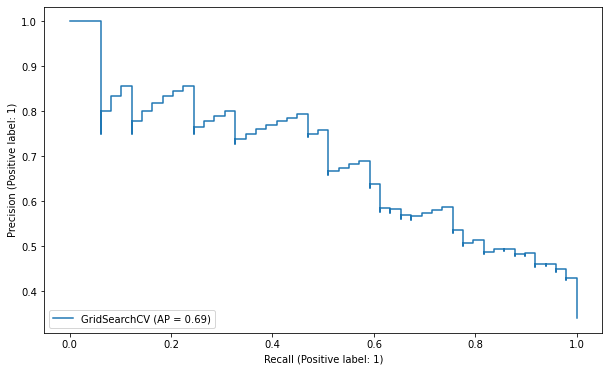

In [46]:
plot_precision_recall_curve(rf_grid_model, X_test, y_test);

In [47]:
# Precision_Recall curve'leri ve score'ları karşılaştırınca Random Forest modelin daha iyi performans verdiği söylenebilir.